In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

sys.path.append('..')
from backend.DB.db import Database

In [2]:
db = Database()

### Aggregation of review sentiments by topic

In [3]:
sql = '''
SELECT topic_name, 
       COUNT(review_id) as num_reviews,
       AVG(sentiment) as mean_sentiment,
       MAX(sentiment) as max_sentiment,
       MIN(sentiment) as min_sentiment,
       SUM(angry) as count_angry 
FROM cooked_reviews
WHERE relevant = true
GROUP BY topic_name
ORDER BY mean_sentiment ASC
'''

results = db.query_sql(sql)
result_set = [{'topic': row[0], 
               'num_reviews': row[1],
               'avg_sentiment': row[2],
               'max_sentiment': row[3],
               'min_sentiment': row[4],
               'angry_guests': row[5]} for row in results]
results_df = pd.DataFrame(result_set)
results_df

,topic,num_reviews,avg_sentiment,max_sentiment,min_sentiment,angry_guests
0,housekeeping,31,3.516129,5,0,2
1,value,59,3.779661,5,1,2
2,hotel condition,49,3.836735,5,1,2
3,amenities,39,3.897436,5,1,0
4,frontdesk service,44,4.000000,5,1,1


How many are angry under each topic?

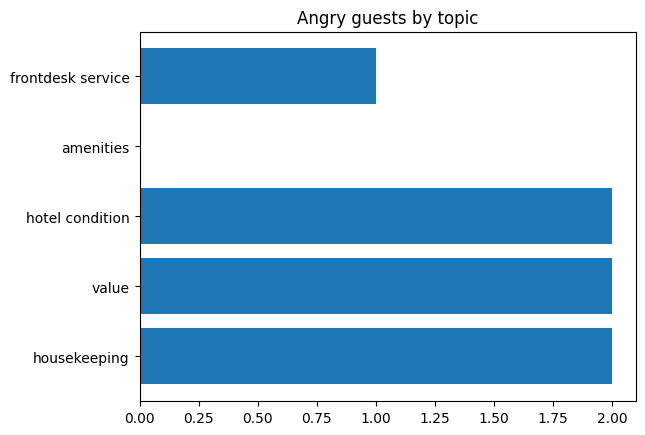

In [4]:
plt.barh(results_df['topic'], results_df['angry_guests'])
plt.title('Angry guests by topic')
plt.show()

### Distribution of sentiments for each topic

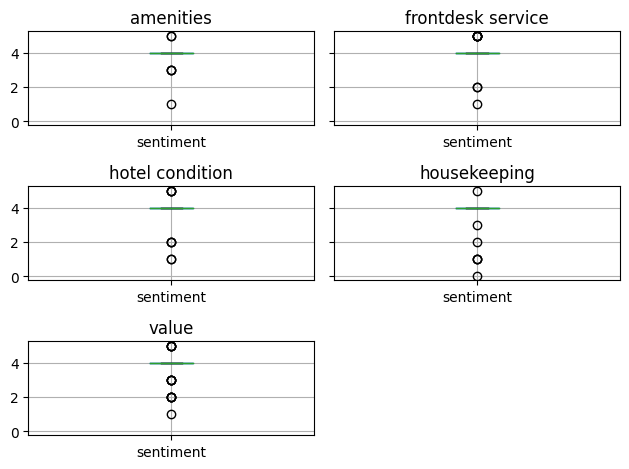

In [5]:
sql = '''
SELECT topic_name, sentiment
FROM cooked_reviews
WHERE relevant = true
ORDER BY topic_name;
'''

results = db.query_sql(sql)
data = [{'topic': t, 'sentiment': s} for t, s in results]
sentiments_df = pd.DataFrame(data)

sentiments_grouped = sentiments_df.groupby(by='topic')
sentiments_grouped.boxplot()
plt.tight_layout()
plt.title("Sentiment by topic")
plt.show()

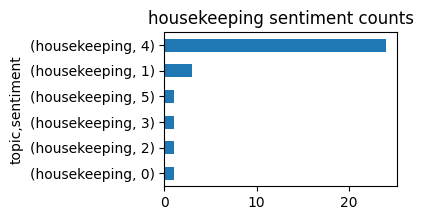

In [6]:
def barplot(df, topic):
   plt.figure(figsize=(3,2))
   df_filtered = df[df['topic'] == topic]
   counts = df_filtered.value_counts()
   counts = counts.sort_values()
   counts.plot(kind='barh')
   plt.title(f'{topic} sentiment counts')
   plt.show()

data = barplot(sentiments_df, 'housekeeping')


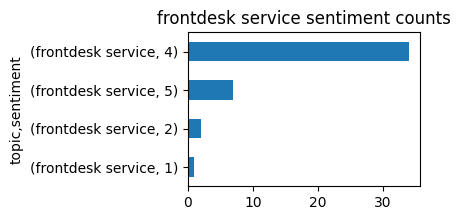

In [7]:
barplot(sentiments_df, 'frontdesk service')

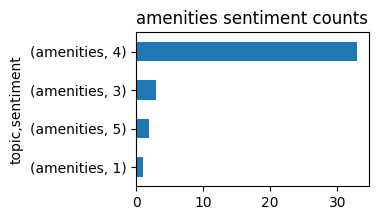

In [8]:
barplot(sentiments_df, 'amenities')

### Angry Guests

Look at categorized reviews flagged as guest being angry from sentiment analysis by GPT

In [9]:
sql = '''
SELECT l.location_description, cr.source_name, cr.review_id, cr.topic_name, cr.sentiment, cr.summary
FROM cooked_reviews AS cr
JOIN locations as l
ON cr.source_name = l.source_name AND  cr.locations_location = l.locations_location
WHERE cr.angry > 0;
'''

results = db.query_sql(sql)
result_set = [{'place': row[0], 
               'review_source': row[1],
               'review_id': row[2],
            'topic': row[3],
            'sentiment': row[4],
            'summary': row[5]} for row in results]
results_df = pd.DataFrame(result_set)

sents = ['N/A', 'very bad', 'bad', 'neutral', 'good', 'very good']
results_df['sentiment'] = results_df['sentiment'].apply(lambda x: sents[x])
results_df

,place,review_source,review_id,topic,sentiment,summary
0,Hotel Moab Downtown,tripadvisor,862481775,housekeeping,very bad,The guest had to clean the room when they arri...
1,Hotel Moab Downtown,tripadvisor,841352567,hotel condition,very bad,The guest was angry about the hotel condition ...
2,Hotel Moab Downtown,tripadvisor,841352567,value,very bad,The guest was angry about the value as they wo...
3,Hampton Inn,tripadvisor,886905031,frontdesk service,bad,The guest had a negative experience during che...
4,Hampton Inn,tripadvisor,894562457,hotel condition,very bad,The guest was very unhappy with the hotel's co...
5,Gonzo Inn,tripadvisor,895909597,value,bad,"The guest was unhappy with the breakfast, whic..."
6,Gonzo Inn,tripadvisor,895313844,housekeeping,very bad,The guest was unhappy with the housekeeping se...


Make it into a sort of report

In [10]:
for index, data in results_df.iterrows():
    print(f'Place: {data["place"]}\nTopic: {data["topic"]}\nSentiment: {data["sentiment"]}')
    print(f'Source: {data["review_source"]}\nReview_ID: {data["review_id"]}')
    print('Summary:')
    pprint(data["summary"])
    print('================================\n')
    


Place: Hotel Moab Downtown
Topic: housekeeping
Sentiment: very bad
Source: tripadvisor
Review_ID: 862481775
Summary:
('The guest had to clean the room when they arrived. The nightstand and desk '
 'were not cleaned with cleaners in a while. The janitorial service took this '
 'rating down.')

Place: Hotel Moab Downtown
Topic: hotel condition
Sentiment: very bad
Source: tripadvisor
Review_ID: 841352567
Summary:
('The guest was angry about the hotel condition as the entire building was '
 'infested with baby roaches.')

Place: Hotel Moab Downtown
Topic: value
Sentiment: very bad
Source: tripadvisor
Review_ID: 841352567
Summary:
('The guest was angry about the value as they would not recommend the place '
 "even to people they don't like due to the roach infestation.")

Place: Hampton Inn
Topic: frontdesk service
Sentiment: bad
Source: tripadvisor
Review_ID: 886905031
Summary:
('The guest had a negative experience during check-in as the manager informed '
 "them that the systems weren't u

In [12]:
sql = '''
SELECT title, review_text, rating FROM raw_reviews
WHERE review_id = 894562457 AND source_name = "tripadvisor";
'''

results = list(db.query_sql(sql))
print(f'{results[0][0]} -- Guest Rating {results[0][2]} stars')
pprint(results[0][1])

I hate Marriott, but… -- Guest Rating 1 stars
('I would never stay in this hotel again. \n'
 '- beds rock hard\n'
 '- noise transmits between floors, ver loud \n'
 '- dirty\n'
 '- needs lots of maintenance \n'
 '- breakfast was trash \n'
 '\n'
 'I would stay at one of the Marriott properties, esp if traveling w family')
